Using Deep learning and pytorch to train a samll deep learning model to predict user ratings for specific movies

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import io
import os
import math
import copy
import pickle
import zipfile
from textwrap import wrap
from pathlib import Path
from itertools import zip_longest
from collections import defaultdict
from urllib.error import URLError
from urllib.request import urlopen

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.optim.lr_scheduler import _LRScheduler

In [3]:
plt.style.use('ggplot')

In [4]:
def  set_random_seed(state=1):
    gens = (np.random.seed, torch.manual_seed,  torch.cuda.manual_seed)
    for set_state in gens:
        set_state(state)

In [5]:
RANDOM_STATE = 1
set_random_seed(RANDOM_STATE)

### Download dataset

In [6]:
def read_data(path):
    files = {}
    for filename in os.listdir(path):
        stem, suffix = os.path.splitext(filename)
        file_path = os.path.join(path, filename)
        print(filename)
        if suffix == '.csv':
            files[stem] = pd.read_csv(file_path)
        elif suffix == '.dat':
            if stem == 'ratings':
                columns = ['userId', 'movieId','rating', 'timestamp']
            else:
                columns = ['movieId', 'title', 'genres']
            data = pd.read_csv(file_path, sep='::', names = columns, engine='python')
            files[stem] = data
    return files['ratings'], files['movies']

In [7]:
# available folders
ratings, movies = read_data('./MovieLens-100k/')

links.csv
u.data
tags.csv
ratings.csv
movies.csv


#### Preview Dataset

In [8]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [9]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [10]:
def tabular_preview(ratings, n = 15):
    """ Create a cross tabular view of users vs movies."""
    
    user_groups = ratings.groupby('userId')['rating'].count()
    top_users = user_groups.sort_values(ascending=False)[:n]
    
    movie_groups = ratings.groupby('movieId')['rating'].count()
    top_movies = movie_groups.sort_values(ascending=False)[:n]
    
    top = (
        
        ratings.
        join(top_users, rsuffix='_r', how='inner', on='userId').
        join(top_movies, rsuffix='_r', how='inner', on='movieId')
    )
    # print(top)
    
    return pd.crosstab(top.userId, top.movieId, top.rating, aggfunc=np.sum)
    

In [11]:
tabular_preview(ratings, 20)

movieId,1,110,260,296,318,356,457,480,527,588,589,593,608,780,1196,1198,1210,1270,2571,2858
userId,,,,,,,,,,,,,,,,,,,,
15,2.0,3.0,5.0,5.0,2.0,1.0,5.0,3.0,4.0,0.5,4.0,5.0,5.0,2.5,5.0,4.0,5.0,5.0,5.0,4.0
23,3.0,3.5,4.5,4.5,5.0,4.5,3.5,3.5,3.5,4.0,3.5,4.5,4.5,3.5,4.5,4.5,4.0,4.5,4.0,3.5
30,4.0,5.0,4.0,5.0,5.0,5.0,5.0,4.0,5.0,5.0,4.0,4.0,5.0,4.0,4.0,5.0,4.0,5.0,3.0,5.0
73,5.0,4.0,4.5,5.0,5.0,5.0,4.0,4.0,5.0,5.0,3.0,4.5,4.0,3.5,5.0,5.0,5.0,5.0,4.5,4.5
212,3.0,5.0,4.0,4.0,4.5,4.0,3.0,3.0,5.0,3.0,3.0,4.0,NaN,3.0,NaN,3.0,NaN,3.0,5.0,4.0
213,3.0,2.5,5.0,NaN,NaN,2.0,4.0,5.0,NaN,3.0,4.0,2.5,2.0,5.0,5.0,3.0,5.0,3.0,4.0,NaN
294,4.0,3.0,4.0,NaN,3.0,4.0,3.5,4.0,4.0,5.0,3.0,NaN,NaN,4.5,4.0,4.5,4.0,4.0,4.5,NaN
311,3.0,3.0,4.0,3.0,4.5,5.0,4.5,4.5,5.0,3.0,4.5,2.0,4.0,4.5,3.0,4.5,3.5,4.5,4.0,NaN
380,4.0,5.0,4.0,5.0,4.0,5.0,NaN,4.0,NaN,4.0,4.0,5.0,4.0,4.0,4.0,NaN,4.0,3.0,5.0,5.0


### Data preparation

In [12]:
def create_dataset(ratings, top=None):
    if top  is not None:
        ratings.groupby('userId')['rating'].count()
        
    unique_users = ratings.userId.unique()
    user_to_index = {old: new for new, old in enumerate(unique_users)}
    new_users = ratings.userId.map(user_to_index)
    
    unique_movies = ratings.movieId.unique()
    movie_to_index = {old: new for new, old in enumerate(unique_movies)}
    new_movies = ratings.movieId.map(movie_to_index)
    
    n_users = unique_users.shape[0]
    n_movies = unique_movies[0]
    
    X = pd.DataFrame({'user_id':new_users, 'movie_id': new_movies})
    y = ratings['rating'].astype(np.float32)
    
    return (n_users, n_movies), (X, y), (user_to_index, movie_to_index)    

In [13]:
(n,m), (X,y), _ = create_dataset(ratings)
print(f'Embeddings {n} user, {m} movies')
print(f'Dataset shape: {X.shape}')
print(f'Target shape: {y.shape}')

Embeddings 671 user, 31 movies
Dataset shape: (100004, 2)
Target shape: (100004,)


- Iterate over the dataset  one batch after another

In [14]:
class ReviewIterator:
    
    def __init__(self, X, y, batch_size = 32, shuffle= True) :
        
        X,y = np.asarray(X), np.asarray(y)
        
        if shuffle:
            index =  np.random.permutation(X.shape[0])
            X,y = X[index], y[index]
            
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.n_batches = int(math.ceil(X.shape[0] // batch_size))
        self._current = 0
        
        
    def __iter__(self):
        return self
    
    def __next__(self):
        return self.next()
    
    
    def next(self):
        if self._current >= self.n_batches:
            raise StopIteration()
        k = self._current
        self._current += 1 
        bs = self.batch_size
        return self.X[k*bs:(k + 1)*bs], self.y[k*bs:(k + 1)*bs]

In [15]:
def batches(X, y, bs=32, shuffle=True):
    for xb, yb in ReviewIterator(X, y, bs, shuffle):
        xb = torch.LongTensor(xb)
        yb = torch.FloatTensor(yb)
        yield xb, yb.view(-1,1)
    

In [16]:
for x_batch, y_batch in batches(X, y, bs=4):
    print(x_batch)
    print(y_batch)
    break

tensor([[ 666, 4231],
        [ 103, 3956],
        [  18,  445],
        [ 394,  427]])
tensor([[4.0000],
        [3.5000],
        [5.0000],
        [5.0000]])


### Embeddings
create nn.module for our embedding network



In [17]:
class EmbeddingNet(nn.Module):
    """
    Creates a dense network with embedding layers.
    
    Args:
    
        n_users:            
            Number of unique users in the dataset.

        n_movies: 
            Number of unique movies in the dataset.

        n_factors: 
            Number of columns in the embeddings matrix.

        embedding_dropout: 
            Dropout rate to apply right after embeddings layer.

        hidden:
            A single integer or a list of integers defining the number of 
            units in hidden layer(s).

        dropouts: 
            A single integer or a list of integers defining the dropout 
            layers rates applyied right after each of hidden layers.
            
    """
    def __init__(self, n_users, n_movies,
                 n_factors=50, embedding_dropout=0.02, 
                 hidden=10, dropouts=0.2):
        super().__init__()
        hidden = get_list(hidden)
        dropouts = get_list(dropouts)
        n_last = hidden[-1]
        
        def gen_layers(n_in):
            """
            A generator that yields a sequence of hidden layers and 
            their activations/dropouts.
            
            Note that the function captures `hidden` and `dropouts` 
            values from the outer scope.
            """
            nonlocal hidden, dropouts
            assert len(dropouts) <= len(hidden)
            
            for n_out, rate in zip_longest(hidden, dropouts):
                yield nn.Linear(n_in, n_out)
                yield nn.ReLU()
                if rate is not None and rate > 0.:
                    yield nn.Dropout(rate)
                n_in = n_out
            
        self.u = nn.Embedding(n_users, n_factors)
        self.m = nn.Embedding(n_movies, n_factors)
        self.drop = nn.Dropout(embedding_dropout)
        self.hidden = nn.Sequential(*list(gen_layers(n_factors * 2)))
        self.fc = nn.Linear(n_last, 1)
        self._init()
        
    def forward(self, users, movies, minmax=None):
        features = torch.cat([self.u(users), self.m(movies)], dim=1)
        x = self.drop(features)
        x = self.hidden(x)
        out = torch.sigmoid(self.fc(x))
        if minmax is not None:
            min_rating, max_rating = minmax
            out = out*(max_rating - min_rating + 1) + min_rating - 0.5
        return out
    
    def _init(self):
        """
        Setup embeddings and hidden layers with reasonable initial values.
        """
        def init(m):
            if type(m) == nn.Linear:
                torch.nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)
                
        self.u.weight.data.uniform_(-0.05, 0.05)
        self.m.weight.data.uniform_(-0.05, 0.05)
        self.hidden.apply(init)
        init(self.fc)
    
    
def get_list(n):
    if isinstance(n, (int, float)):
        return [n]
    elif hasattr(n, '__iter__'):
        return list(n)
    raise TypeError('layers configuraiton should be a single number or a list of numbers')

In [18]:
# example of creating a single hidden layer and dropout
EmbeddingNet(n,m, n_factors=150, hidden=100, dropouts=0.5)

EmbeddingNet(
  (u): Embedding(671, 150)
  (m): Embedding(31, 150)
  (drop): Dropout(p=0.02, inplace=False)
  (hidden): Sequential(
    (0): Linear(in_features=300, out_features=100, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
  )
  (fc): Linear(in_features=100, out_features=1, bias=True)
)

In [19]:
#### Cyclical Learning Rate(CLR)

class CyclicLR(_LRScheduler):
    
    def __init__(self, optimizer, schedule, last_epoch=-1):
        assert callable(schedule)
        self.schedule = schedule
        super().__init__(optimizer, last_epoch)
    
    def get_lr(self):
        return [self.schedule(self.last_epoch, lr) for lr in self.base_lrs]


In [20]:
def triangular(step_size, max_lr, method = 'triangular', gamma=0.99):
    
    def scheduler(epoch, base_lr):
        period = 2 * step_size
        cycle = math.floor(1 + epoch/period)
        x = abs(epoch/step_size -  2*cycle + 1)
        delta = (max_lr - base_lr)*max(0, (1 - x))
        
        if method == 'triangular':
            pass
        elif method == 'triangular2':
            delta /= float(2 ** (cycle - 1))
        elif method == 'exp_range':
            delta *= (gamma ** epoch)
        else:
            raise ValueError('unexpected method: %s' % method)
        
        return base_lr + delta
    
    
    return scheduler

In [21]:
def cosine(t_max, eta_min=0):
    
    def scheduler(epoch, base_lr):
        t = epoch * t_max
        return eta_min + (base_lr - eta_min) * (1 + math.cos(math.pi*t/t_max))/2
    return scheduler

In [22]:
def plot_lr(schedule):
    ts = list(range(1000))
    y = [schedule(t, 0.001) for t in ts]
    plt.plot(ts, y)

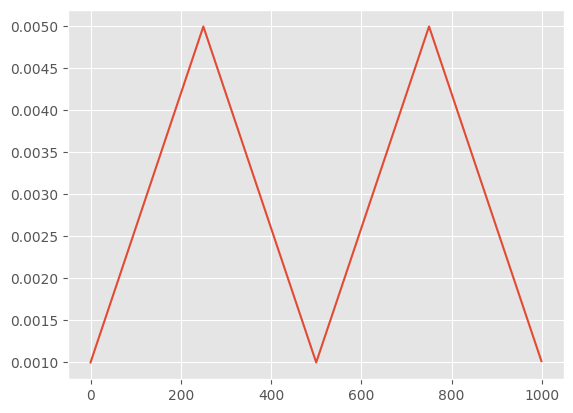

In [23]:
plot_lr(triangular(250, 0.005))


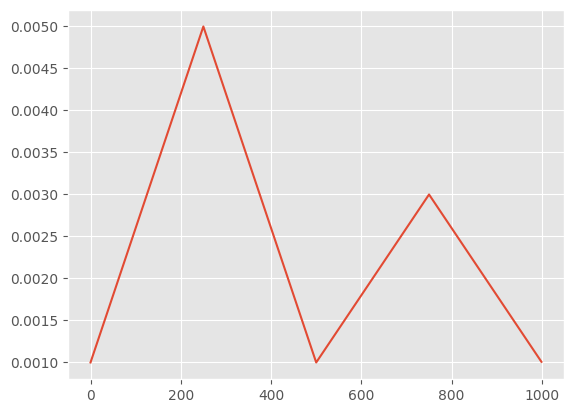

In [24]:
plot_lr(triangular(250, 0.005, 'triangular2'))


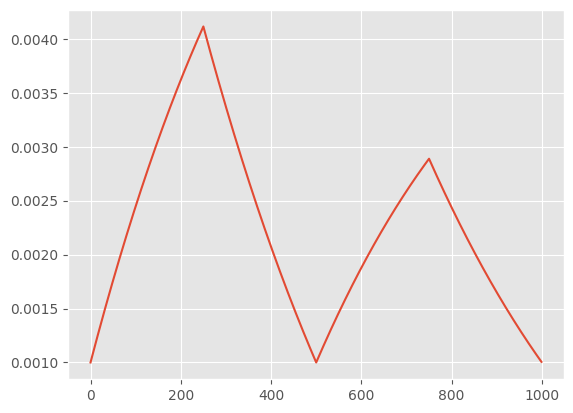

In [25]:
plot_lr(triangular(250, 0.005, 'exp_range', gamma=0.999))

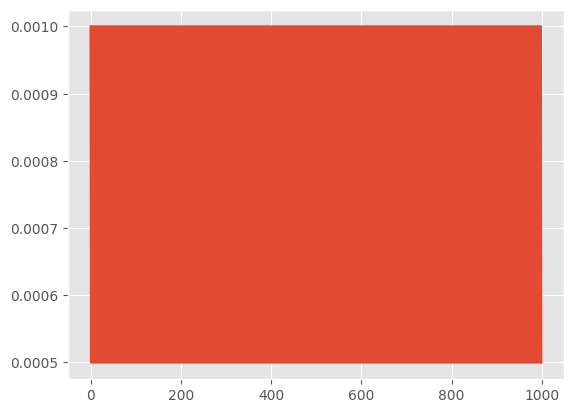

In [26]:
plot_lr(cosine(t_max=500, eta_min=0.0005))

#### Training loop

In [27]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
datasets = {'train': (X_train, y_train), 'val': (X_valid, y_valid)}
dataset_sizes = {'train': len(X_train), 'val': len(X_valid)}

In [28]:
minmax = ratings.rating.min(), ratings.rating.max()
minmax

(0.5, 5.0)

In [29]:
net = EmbeddingNet(
    n_users=n, n_movies=m, 
    n_factors=150, hidden=[500, 500, 500], 
    embedding_dropout=0.05, dropouts=[0.5, 0.5, 0.25])

In [30]:
lr = 1e-3
wd = 1e-5
bs = 2000 
n_epochs = 100
patience = 10
no_improvements = 0
best_loss = np.inf
best_weights = None
history = []
lr_history = []

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

net.to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
iterations_per_epoch = int(math.ceil(dataset_sizes['train'] // bs))
scheduler = CyclicLR(optimizer, cosine(t_max=iterations_per_epoch * 2, eta_min=lr/10))

for epoch in range(n_epochs):
    stats = {'epoch': epoch + 1, 'total': n_epochs}
    
    for phase in ('train', 'val'):
        training = phase == 'train'
        running_loss = 0.0
        n_batches = 0
        batch_num = 0
        for batch in batches(*datasets[phase], shuffle=training, bs=bs):
            x_batch, y_batch = [b.to(device) for b in batch]
            optimizer.zero_grad()
            # compute gradients only during 'train' phase
            with torch.set_grad_enabled(training):
                outputs = net(x_batch[:, 0], x_batch[:, 1], minmax)
                loss = criterion(outputs, y_batch)
                
                # don't update weights and rates when in 'val' phase
                if training:
                    scheduler.step()
                    loss.backward()
                    optimizer.step()
                    lr_history.extend(scheduler.get_lr())
                    
            running_loss += loss.item()
            
        epoch_loss = running_loss / dataset_sizes[phase]
        stats[phase] = epoch_loss
        
        # early stopping: save weights of the best model so far
        if phase == 'val':
            if epoch_loss < best_loss:
                print('loss improvement on epoch: %d' % (epoch + 1))
                best_loss = epoch_loss
                best_weights = copy.deepcopy(net.state_dict())
                no_improvements = 0
            else:
                no_improvements += 1
                
    history.append(stats)
    print('[{epoch:03d}/{total:03d}] train: {train:.4f} - val: {val:.4f}'.format(**stats))
    if no_improvements >= patience:
        print('early stopping after epoch {epoch:03d}'.format(**stats))
        break

IndexError: index out of range in self

In [33]:
x_batch[:,1]

tensor([ 504,  434,  335,  ...,  662, 2340,  652])

In [34]:
net(x_batch[:, 0], x_batch[:, 1], minmax)

IndexError: index out of range in self